In [27]:
import os
import shutil
import random


#splitting data into training and validation 
dataset_path = "c:/Fasal_Guru/data"  # Absolute path to avoid issues
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

split_ratio = 0.8

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path) and class_name not in ["train", "val"]:
        train_class_path = os.path.join(train_path, class_name)
        val_class_path = os.path.join(val_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)

        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
        
        if not images:
            print(f"No images found in: {class_path}")
            continue
        
        random.shuffle(images)
        split_idx = int(len(images) * split_ratio)
        train_images, val_images = images[:split_idx], images[split_idx:]

        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_path, img))

        for img in val_images:
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_path, img))

        # Force delete non-empty directories
        shutil.rmtree(class_path, ignore_errors=True)

        print(f" Processed '{class_name}': {len(train_images)} train, {len(val_images)} val")

print(" Dataset successfully split into train/ and val/")


 Processed 'Cashew anthracnose': 44 train, 11 val
 Processed 'Cashew gumosis': 313 train, 79 val
 Processed 'Cashew healthy': 1094 train, 274 val
 Processed 'Cashew leaf miner': 1102 train, 276 val
 Processed 'Cashew red rust': 1345 train, 337 val
 Processed 'Cassava bacterial blight': 2091 train, 523 val
 Processed 'Cassava brown spot': 1184 train, 297 val
 Processed 'Cassava green mite': 812 train, 203 val
 Processed 'Cassava healthy': 954 train, 239 val
 Processed 'Cassava mosaic': 964 train, 241 val
 Processed 'Maize fall armyworm': 228 train, 57 val
 Processed 'Maize grasshoper': 538 train, 135 val
 Processed 'Maize healthy': 166 train, 42 val
 Processed 'Maize leaf beetle': 758 train, 190 val
 Processed 'Maize leaf blight': 804 train, 202 val
 Processed 'Maize leaf spot': 1007 train, 252 val
 Processed 'Maize streak virus': 783 train, 196 val
 Processed 'Tomato healthy': 376 train, 94 val
 Processed 'Tomato leaf blight': 1040 train, 261 val
 Processed 'Tomato leaf curl': 414 trai

In [46]:
#removing corrupted images
from PIL import Image
import os

dataset_path = "../data/train"  

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify if the image is readable
            except (IOError, OSError):
                print(f"Corrupted image found: {img_path}")
                os.remove(img_path)  # Remove the corrupted file
                print(f"Deleted: {img_path}")

print("Dataset checked! Corrupted images removed.")

dataset_path = "../data/val"  

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify if the image is readable
            except (IOError, OSError):
                print(f"Corrupted image found: {img_path}")
                os.remove(img_path)  # Remove the corrupted file
                print(f"Deleted: {img_path}")

print("Dataset checked! Corrupted images removed.")


Dataset checked! Corrupted images removed.
Dataset checked! Corrupted images removed.


In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [48]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(15),
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

dataset_path = "c:/Fasal_Guru/data"

# Load dataset using ImageFolder
train_data = ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_data = ImageFolder(root=os.path.join(dataset_path, "val"), transform=transform)

# Create DataLoaders for batch processing
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

# Get class names
class_names = train_data.classes
num_classes = len(class_names)
print(f"Detected classes: {class_names}")


Detected classes: ['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']


In [49]:
# load pretrained ResNet18 model
model = models.resnet18(pretrained=True)
#modify the last layer
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [51]:
model = model.to(device)

In [52]:
criterion = nn.CrossEntropyLoss()  # Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam Optimizer


In [38]:
from PIL import Image
import os

def check_corrupt_images(root_dir):
    corrupted_files = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if image is readable
            except (OSError, IOError):
                print(f"Corrupt image found: {file_path}")
                corrupted_files.append(file_path)

    return corrupted_files

dataset_path = "c:/Fasal_Guru/data/train"
corrupt_images = check_corrupt_images(dataset_path)

# Delete corrupt images
for file in corrupt_images:
    os.remove(file)
    print(f"Deleted: {file}")

print("✅ Corrupt images removed.")


✅ Corrupt images removed.


In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_dataset_path = "c:/Fasal_Guru/data/train"
val_dataset_path = "c:/Fasal_Guru/data/val"

# remove corrupt images
def remove_corrupt_images(dataset_path):
    for root, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Corrupt image found and removed: {file_path}")
                os.remove(file_path)

# Remove corrupt images from train and val folders
remove_corrupt_images(train_dataset_path)
remove_corrupt_images(val_dataset_path)

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(os.listdir(root_dir))}

        for label in os.listdir(root_dir):  # Each folder is a class
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    file_path = os.path.join(label_path, file)
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # Check if the image is readable
                        self.image_paths.append(file_path)
                        self.labels.append(self.class_to_idx[label])  # Convert to numerical label
                    except (IOError, SyntaxError):
                        print(f"Skipping corrupt image: {file_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Get next valid image

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load Dataset
train_dataset = CustomDataset(root_dir=train_dataset_path, transform=transform)
val_dataset = CustomDataset(root_dir=val_dataset_path, transform=transform)

# Check dataset length
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Ensure dataset is not empty
if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("Dataset is empty after removing corrupt images!")

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(os.listdir(train_dataset_path))  # Get number of classes
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
print("Model Training...")
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("reached 1st")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        print("reached 2nd")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Save Model
print("Saving trained model...")
torch.save(model.state_dict(), "resnet_finetuned.pth")
print("Model saved as resnet_finetuned.pth")

Train dataset size: 18784
Validation dataset size: 4712


c:\Users\Ramsha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ramsha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Training...
reached 1st
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2nd
reached 2n

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn


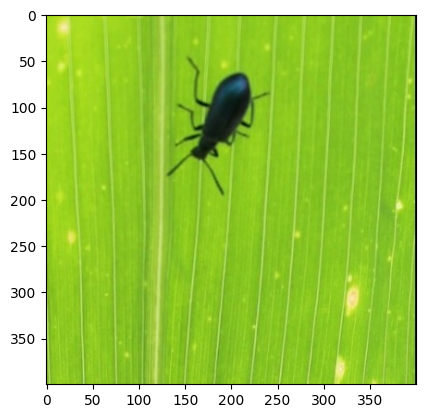

In [3]:
import matplotlib.pyplot as plt

from PIL import Image
img = Image.open('C:/Fasal_Guru/data/val/Maize leaf beetle/leaf beetle3_.jpg')
plt.imshow(img)

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(os.listdir("c:/Fasal_Guru/data/train")) 
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)  
model.load_state_dict(torch.load("resnet_finetuned.pth", map_location=device))
model.to(device)
model.eval()  

print("Model loaded successfully!")


c:\Users\Ramsha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ramsha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [7]:
train_dataset_path = "c:/Fasal_Guru/data/train"
class_names = sorted(os.listdir(train_dataset_path))

print("Class labels:", class_names)

Class labels: ['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']


In [8]:
def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)  # Forward pass
        _, predicted_class = torch.max(outputs, 1)  # Get the highest probability class

    return class_names[predicted_class.item()]  # Map index to class label


In [11]:
image_path = "C:/Fasal_Guru/data/val/Tomato septoria leaf spot/septoria leaf spot41_.jpg"  # Example image path
prediction = predict_image(image_path, model, transform, class_names)
print(f"Predicted class: {prediction}")


Predicted class: Tomato septoria leaf spot
